In [87]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, mlp_train_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=1220
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',100)
pd.options.display.float_format = "{:.2f}".format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Engineering
datasets: iksan/nonsan/paju
1. Combine(datasets)
2. Conversion(scale)
3. Filtering 
4. Normalization(manual)

In [51]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = ['pathloss']

print("\nADD data description")
print(addData.describe())
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])
print("\nSample - ADD data")
print(addData.sample())
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].head())

ADD data preprocessing
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
Combined data set: (31188, 8)
type filtering(before):(31188, 8)
type filtering(after):(21210, 8)
Dataframe before add new terms: (21210, 8)
Dataframe after add constant feature: (21210, 19)
Iksan data: (21210, 19)

ADD data preprocessing
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(14603, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(14603, 4)
../data/PLdata_nons

In [68]:
%autoreload

targetCols = ['logDistance', 'pathloss']
xCols = ['logDistance']
yCols = 'pathloss'

print(addData[xCols].describe())

X = np.array(addData[xCols])
Y = np.array(addData[yCols])

       logDistance
count     79125.00
mean          3.31
std           0.12
min           3.00
25%           3.23
50%           3.33
75%           3.40
max           3.48


In [80]:
print("Linear Regression train/test Error")

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

trainErrSum, testErrSum = 0, 0
i = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = Ridge(alpha=0.001)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError

    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

Linear Regression train/test Error
#1 Error(RMSE)-train:16.22871678121877 / test:16.126099138813863
#2 Error(RMSE)-train:16.18444223120921 / test:16.302835251966712
#3 Error(RMSE)-train:16.20998621708762 / test:16.20101327071521
#4 Error(RMSE)-train:16.216740125572368 / test:16.173888953941507
#5 Error(RMSE)-train:16.20081000917733 / test:16.237868837819423

Average train error:16.21 | Average test error:16.21


In [98]:
%autoreload
print("ANN-MLP Regression train/test Error")

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

modelList = []
dataSet = []
trainErrSum, testErrSum = 0, 0
i = 1
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression(X_train, y_train.flatten(), (60,), activation='logistic', optimizer='lbfgs')

#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))

    trainErrSum += trainError
    testErrSum += testError

    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))   
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/ann_model_' + str(i) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:15.992357161077209 / test:16.07536798175226
#2 Error(RMSE)-train:16.01847997485381 / test:16.020882276850138
#3 Error(RMSE)-train:15.605405343233054 / test:15.498322497624672
#4 Error(RMSE)-train:16.01935350651996 / test:16.021682744991864
#5 Error(RMSE)-train:15.704787560606462 / test:15.78218111378987

Average train error:15.87 | Average test error:15.88


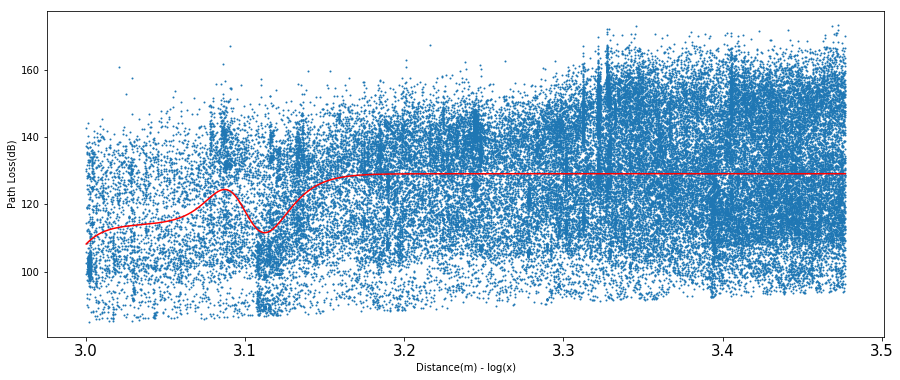

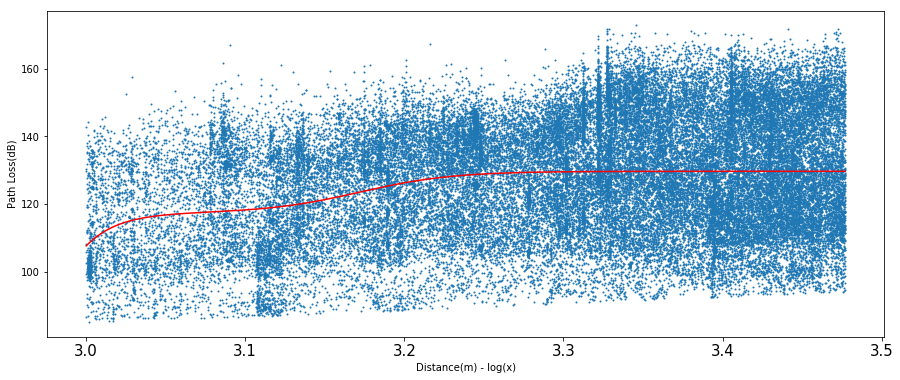

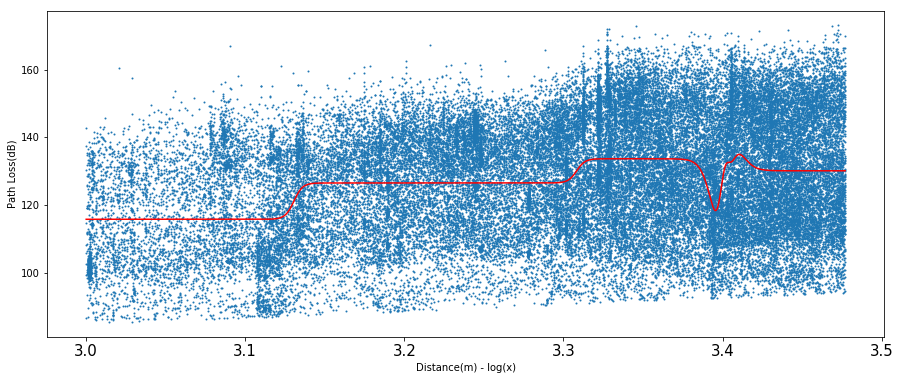

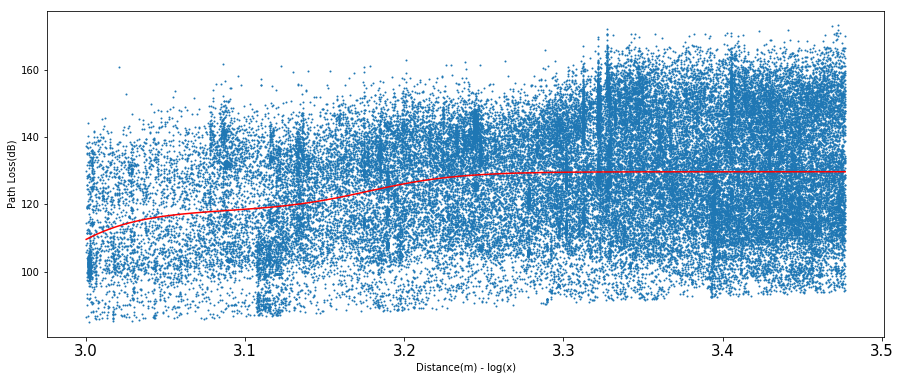

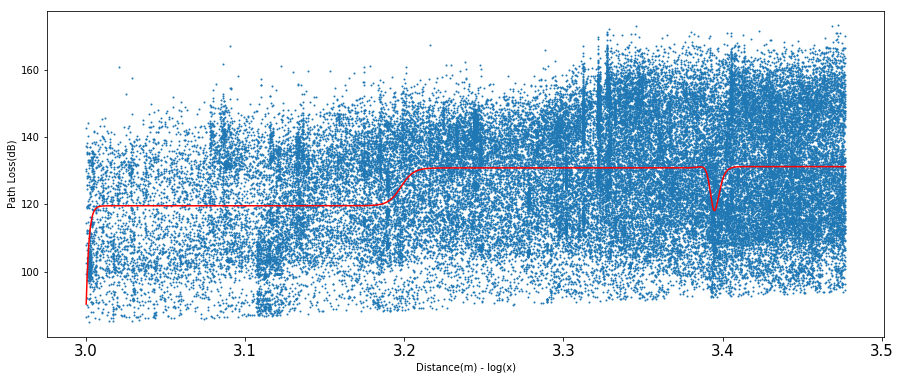

In [99]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    mlp_train_graph(model, X_train, y_train, 'logistic', 'lbfgs')
    i+=1

In [114]:
%autoreload
i = 1
coefficientSum, interceptSum = 0, 0

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:

    print("Equation Derivation for trainset #{}".format(i))

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = LinearRegression().fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"Error(RMSE)-train:{}/test:{}".format(trainError,testError))
#     print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"Error(RMSE)-train:{}/test:{}".format(RMSE_LIN_TRAIN,RMSE_LIN_TEST))
#     print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
#     print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)

    
    print("\nObjective Function with manual normalization data")
    print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))    

    coefficientSum += linearModel.coef_[0]
    interceptSum += linearModel.intercept_
    
    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    i+=1
i-=1
coefficient, intercept = coefficientSum/i, interceptSum/i
print("="*120)
print("\nObjective Function")
print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(coefficient,intercept))
f = lambda x: coefficient*x + intercept
pred = f(X)
print("Linear Model Error(RMSE):",np.sqrt(mean_squared_error(pred, Y)))

Equation Derivation for trainset #1
ANN-Model-1Error(RMSE)-train:15.992357161077209/test:16.07536798175226
MultiLinear-1Error(RMSE)-train:16.951729636642963/test:16.242768164182063

Objective Function with manual normalization data
L_pathloss =  26.76log_d +  38.92
RMSE(ANN-MultiLinear): 3.1384267692811707
Equation Derivation for trainset #2
ANN-Model-2Error(RMSE)-train:16.01847997485381/test:16.020882276850138
MultiLinear-2Error(RMSE)-train:17.108193848018026/test:16.181734902449065

Objective Function with manual normalization data
L_pathloss =  32.02log_d +  21.52
RMSE(ANN-MultiLinear): 2.2501082927311993
Equation Derivation for trainset #3
ANN-Model-3Error(RMSE)-train:15.605405343233054/test:15.498322497624672
MultiLinear-3Error(RMSE)-train:17.04126315129953/test:16.148185195560288

Objective Function with manual normalization data
L_pathloss =  29.58log_d +  29.60
RMSE(ANN-MultiLinear): 4.618900851680963
Equation Derivation for trainset #4
ANN-Model-4Error(RMSE)-train:16.019353506

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.06         -1.29       -0.07        0.00                     0.05             0.03                     -1.68
std           0.00          0.92        0.00        0.00                     0.00             0.00                      1.33
min          -0.06         -2.87       -0.07        0.00                     0.05             0.03                     -3.95
25%          -0.06         -2.08       -0.07        0.00                     0.05             0.03                     -2.82
5

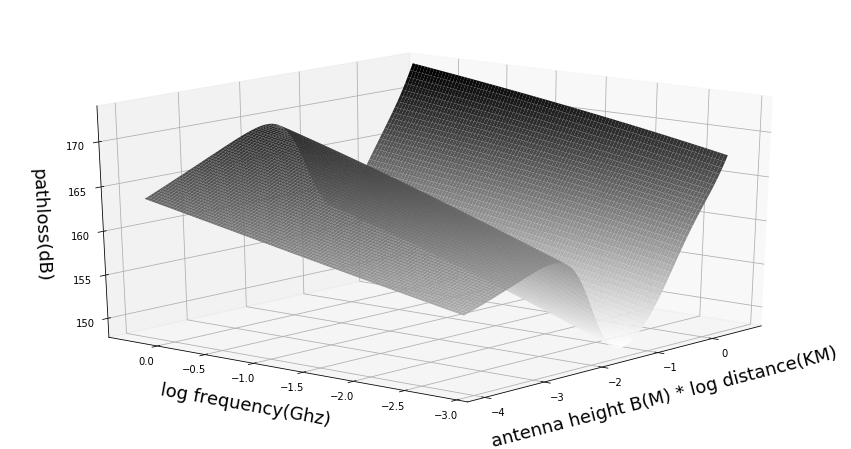

3D graph for log distance and log frequency - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.01         -0.70       -0.07        0.00                    -0.15            -0.15                     -1.68
std           0.00          1.27        0.00        0.00                     0.00             0.00                      1.32
min          -0.01         -2.87       -0.07        0.00                    -0.15            -0.15                     -3.95
25%          -0.01         -1.78       -0.07        0.00                    -0.15            -0.15                     -2.82
5

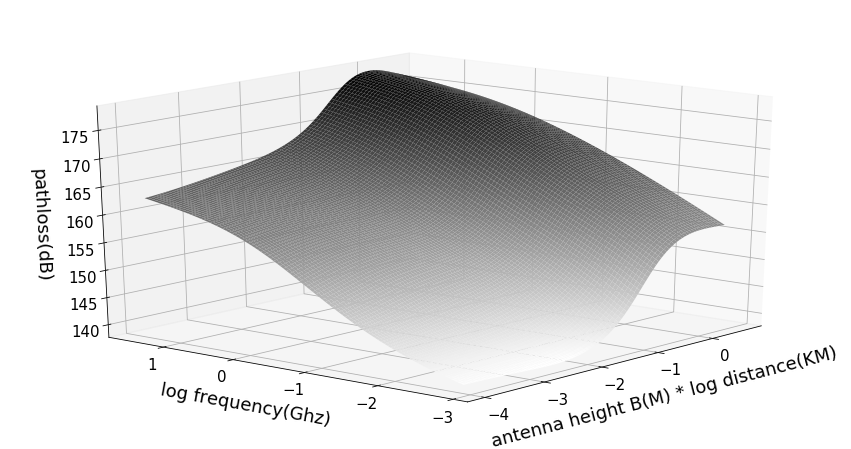

3D graph for log distance and log frequency - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean         -0.02         -0.70        0.10        0.00                     0.18             0.18                     -1.68
std           0.00          1.27        0.00        0.00                     0.00             0.00                      1.33
min          -0.02         -2.87        0.10        0.00                     0.18             0.18                     -3.95
25%          -0.02         -1.78        0.10        0.00                     0.18             0.18                     -2.82
5

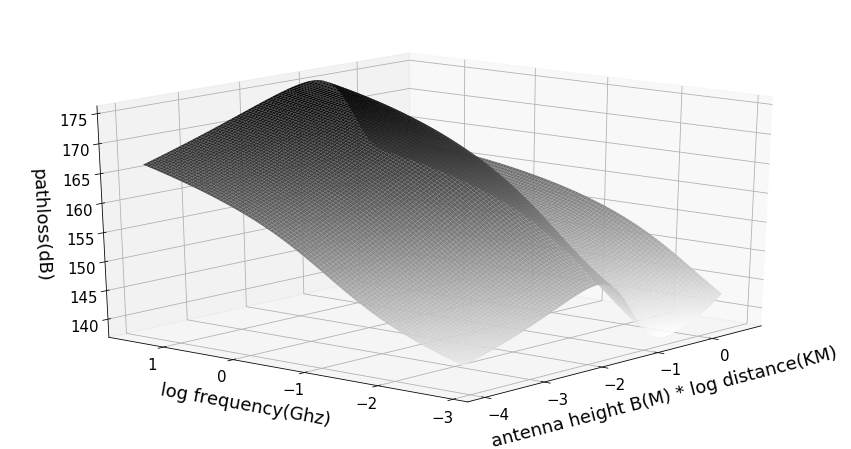

3D graph for log distance and log frequency - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.03         -0.70       -0.07        0.00                    -0.11            -0.11                     -1.68
std           0.00          1.27        0.00        0.00                     0.00             0.00                      1.33
min           0.03         -2.87       -0.07        0.00                    -0.11            -0.11                     -3.95
25%           0.03         -1.78       -0.07        0.00                    -0.11            -0.11                     -2.82
5

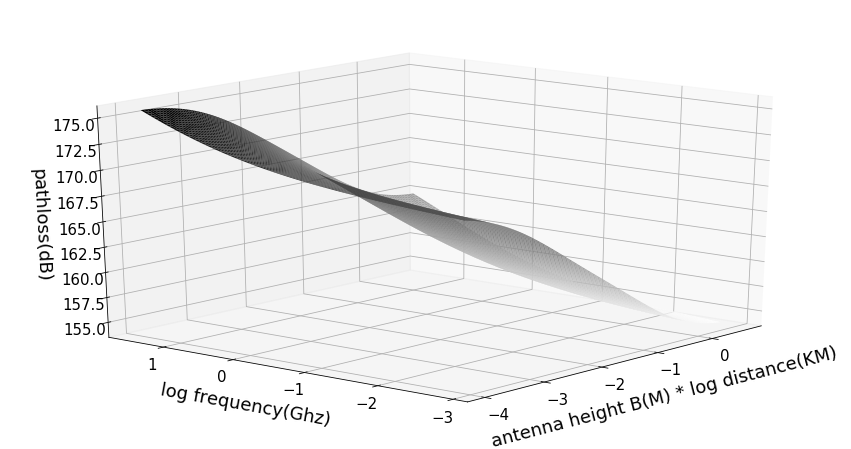

3D graph for log distance and log frequency - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
count     10000.00      10000.00    10000.00    10000.00                 10000.00         10000.00                  10000.00
mean          0.06         -0.70        0.11        0.00                     0.03             0.04                     -1.27
std           0.00          1.27        0.00        0.00                     0.00             0.00                      1.09
min           0.06         -2.87        0.11        0.00                     0.03             0.04                     -3.13
25%           0.06         -1.78        0.11        0.00                     0.03             0.04                     -2.20
5

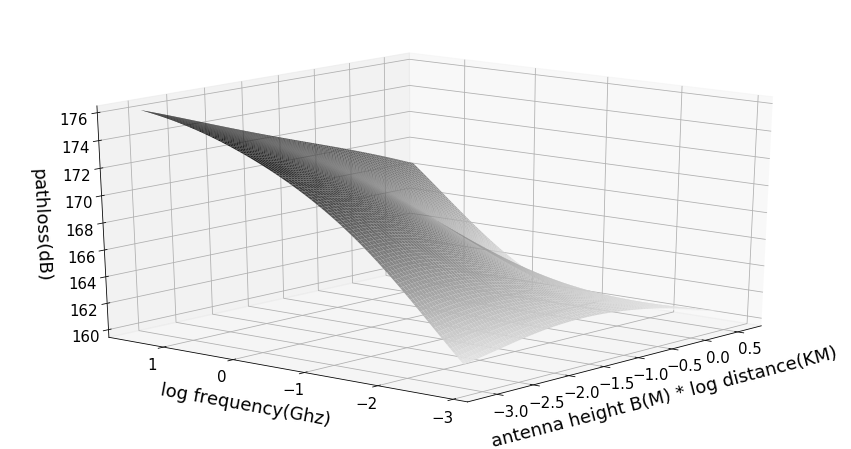

In [36]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log frequency - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logFrequency']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","log frequency(Ghz)","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=xCols),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height TB/TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000     10000.0     10000.0      10000.00000               10000.00000
mean      -0.15102       0.14243         0.0         0.0          0.00304                   0.26271
std        0.00000       0.00000         0.0         0.0          0.96624                   0.75941
min       -0.15102       0.14243         0.0         0.0         -1.65380                  -1.03947
25%       -0.15102       0.14243         0.0         0.0         -0.82538                  -0.38838
50%       -0.15102       0.14243         0.0         0.0          0.00304                   0.26271
75%       -0.15102       0.14243         0.0         0.0     

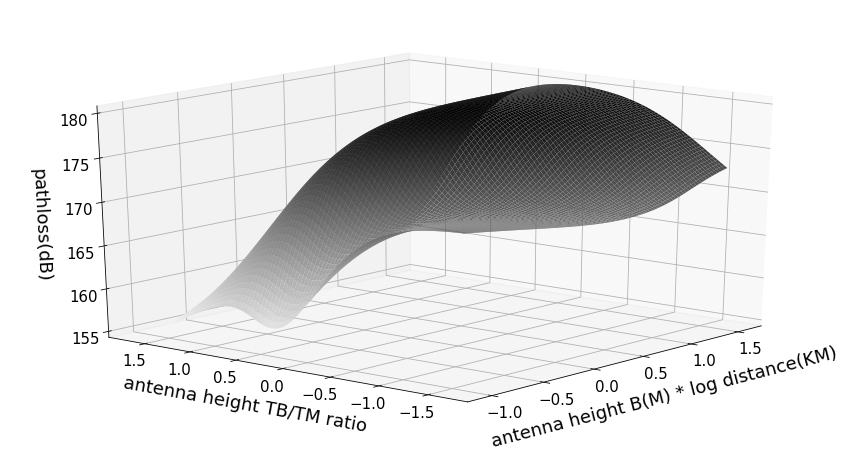

3D graph for log distance and log antenna height TB/TM ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000     10000.0     10000.0      10000.00000               10000.00000
mean   2.37289e-01       0.14243         0.0         0.0          0.00304                   0.55748
std    2.77570e-17       0.00000         0.0         0.0          0.96624                   0.92462
min    2.37289e-01       0.14243         0.0         0.0         -1.65380                  -1.02799
25%    2.37289e-01       0.14243         0.0         0.0         -0.82538                  -0.23525
50%    2.37289e-01       0.14243         0.0         0.0          0.00304                   0.55748
75%    2.37289e-01       0.14243         0.0         0.0     

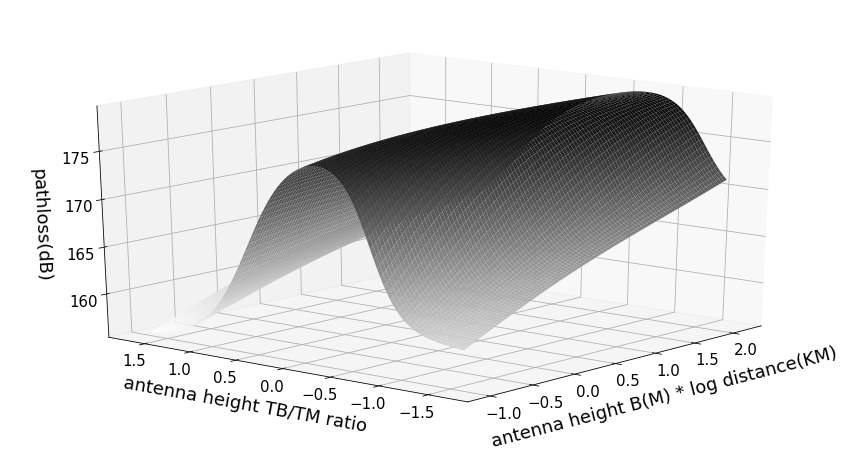

3D graph for log distance and log antenna height TB/TM ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000     10000.0     10000.0      10000.00000               10000.00000
mean   8.40682e-02      -0.07913         0.0         0.0          0.00304                   0.55174
std    2.77570e-17       0.00000         0.0         0.0          0.96624                   0.92797
min    8.40682e-02      -0.07913         0.0         0.0         -1.65380                  -1.03947
25%    8.40682e-02      -0.07913         0.0         0.0         -0.82538                  -0.24387
50%    8.40682e-02      -0.07913         0.0         0.0          0.00304                   0.55174
75%    8.40682e-02      -0.07913         0.0         0.0     

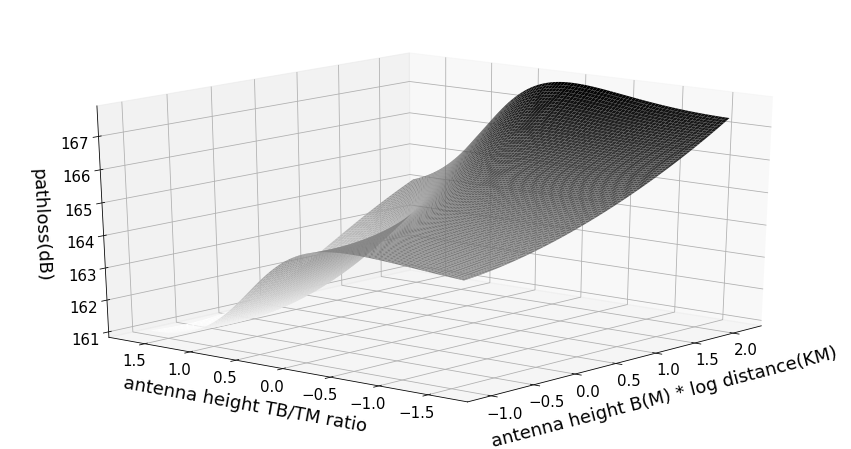

3D graph for log distance and log antenna height TB/TM ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04     10000.0     10000.0      10000.00000               10000.00000
mean      -0.27282  -7.91262e-02         0.0         0.0         -0.21640                   0.55174
std        0.00000   2.77570e-17         0.0         0.0          0.83827                   0.92797
min       -0.27282  -7.91262e-02         0.0         0.0         -1.65380                  -1.03947
25%       -0.27282  -7.91262e-02         0.0         0.0         -0.93510                  -0.24387
50%       -0.27282  -7.91262e-02         0.0         0.0         -0.21640                   0.55174
75%       -0.27282  -7.91262e-02         0.0         0.0     

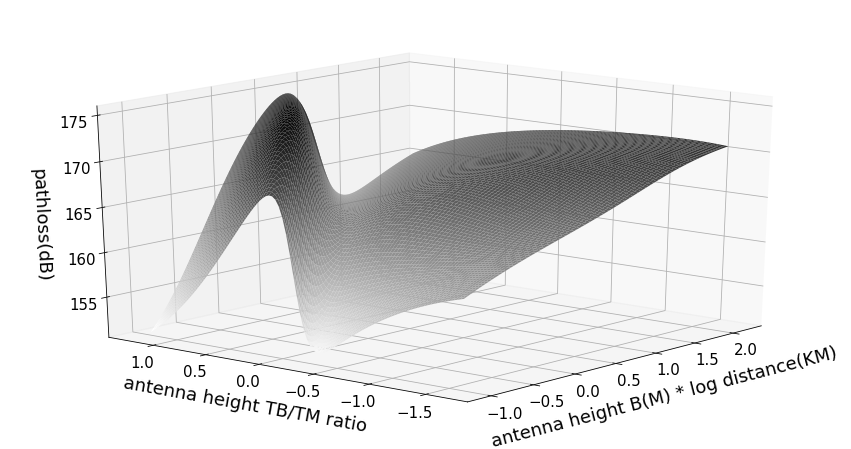

3D graph for log distance and log antenna height TB/TM ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04     10000.0     10000.0      10000.00000               10000.00000
mean   9.39429e-02  -1.16052e-01         0.0         0.0          0.00304                   0.55174
std    2.77570e-17   1.38785e-17         0.0         0.0          0.96624                   0.92797
min    9.39429e-02  -1.16052e-01         0.0         0.0         -1.65380                  -1.03947
25%    9.39429e-02  -1.16052e-01         0.0         0.0         -0.82538                  -0.24387
50%    9.39429e-02  -1.16052e-01         0.0         0.0          0.00304                   0.55174
75%    9.39429e-02  -1.16052e-01         0.0         0.0     

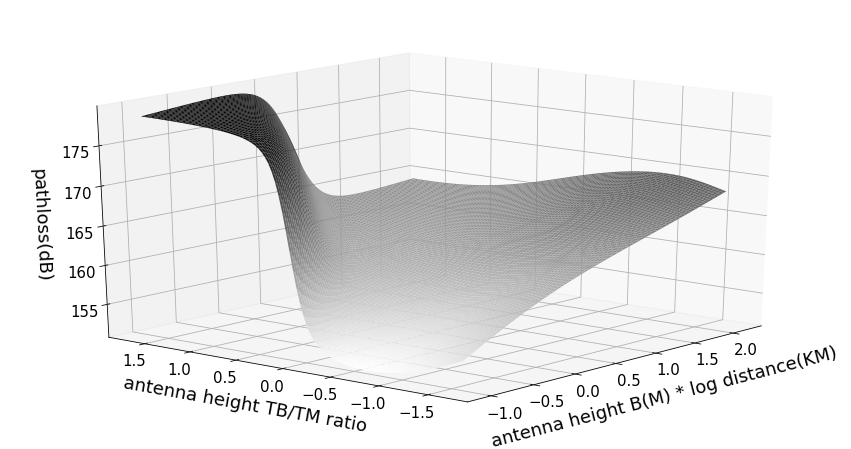

In [7]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height TB/TM ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logHeightTratio']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000     10000.0     10000.0      1.00000e+04               10000.00000
mean      -0.15102       0.14243         0.0         0.0     -1.01818e-01                   0.26271
std        0.00000       0.00000         0.0         0.0      4.16354e-17                   0.75941
min       -0.15102       0.14243         0.0         0.0     -1.01818e-01                  -1.03947
25%       -0.15102       0.14243         0.0         0.0     -1.01818e-01                  -0.38838
50%       -0.15102       0.14243         0.0         0.0     -1.01818e-01                   0.26271
75%       -0.15102       0.14243         0.0         0.0     -1.0

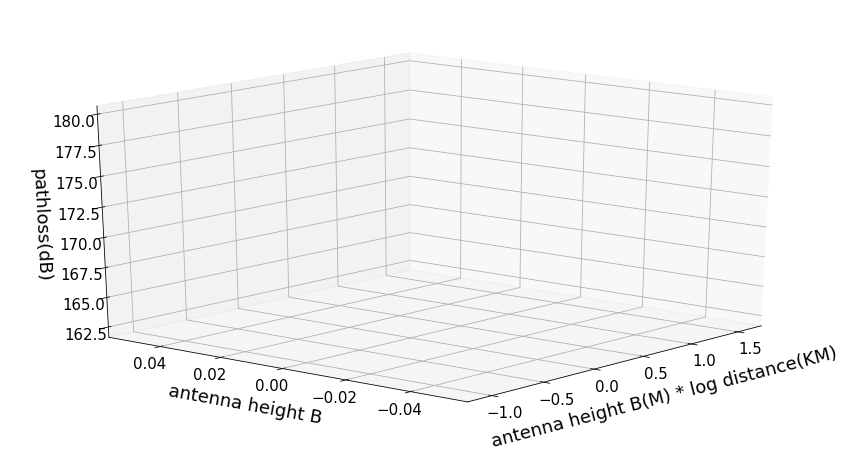

3D graph for log distance and log antenna height B ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000     10000.0     10000.0      1.00000e+04               10000.00000
mean   2.37289e-01       0.14243         0.0         0.0      9.89345e-02                   0.55748
std    2.77570e-17       0.00000         0.0         0.0      2.77570e-17                   0.92462
min    2.37289e-01       0.14243         0.0         0.0      9.89345e-02                  -1.02799
25%    2.37289e-01       0.14243         0.0         0.0      9.89345e-02                  -0.23525
50%    2.37289e-01       0.14243         0.0         0.0      9.89345e-02                   0.55748
75%    2.37289e-01       0.14243         0.0         0.0      9.8

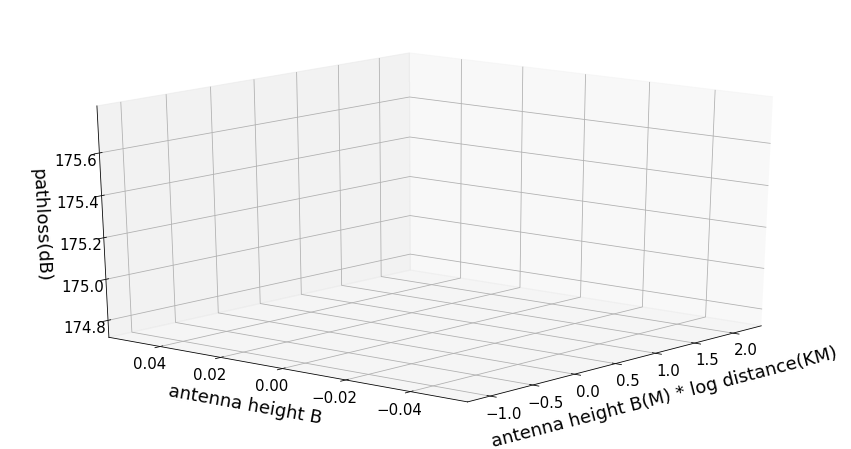

3D graph for log distance and log antenna height B ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000     10000.0     10000.0      1.00000e+04               10000.00000
mean   8.40682e-02      -0.07913         0.0         0.0      1.76116e-01                   0.55174
std    2.77570e-17       0.00000         0.0         0.0      2.77570e-17                   0.92797
min    8.40682e-02      -0.07913         0.0         0.0      1.76116e-01                  -1.03947
25%    8.40682e-02      -0.07913         0.0         0.0      1.76116e-01                  -0.24387
50%    8.40682e-02      -0.07913         0.0         0.0      1.76116e-01                   0.55174
75%    8.40682e-02      -0.07913         0.0         0.0      1.7

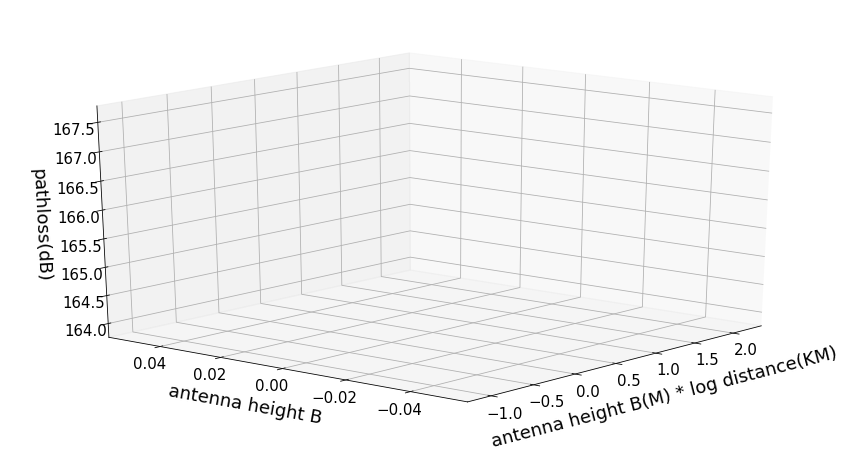

3D graph for log distance and log antenna height B ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04     10000.0     10000.0      1.00000e+04               10000.00000
mean      -0.27282  -7.91262e-02         0.0         0.0     -1.35412e-01                   0.55174
std        0.00000   2.77570e-17         0.0         0.0      5.55139e-17                   0.92797
min       -0.27282  -7.91262e-02         0.0         0.0     -1.35412e-01                  -1.03947
25%       -0.27282  -7.91262e-02         0.0         0.0     -1.35412e-01                  -0.24387
50%       -0.27282  -7.91262e-02         0.0         0.0     -1.35412e-01                   0.55174
75%       -0.27282  -7.91262e-02         0.0         0.0     -1.3

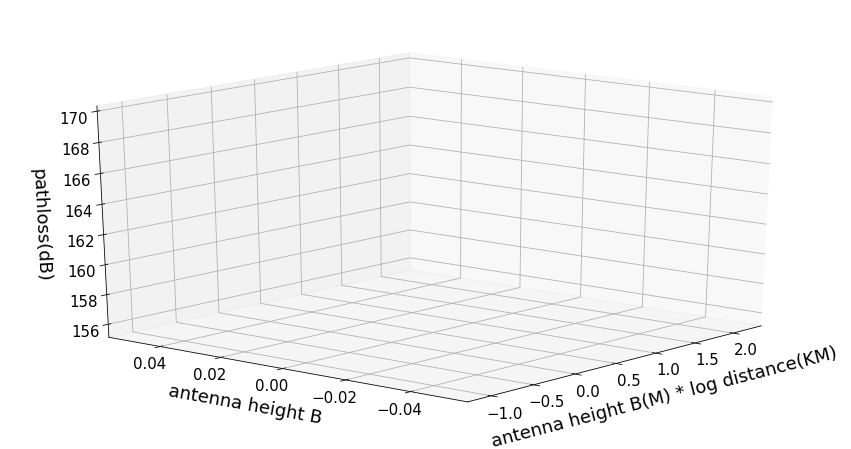

3D graph for log distance and log antenna height B ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04     10000.0     10000.0      1.00000e+04               10000.00000
mean   9.39429e-02  -1.16052e-01         0.0         0.0     -3.46689e-02                   0.55174
std    2.77570e-17   1.38785e-17         0.0         0.0      6.93924e-18                   0.92797
min    9.39429e-02  -1.16052e-01         0.0         0.0     -3.46689e-02                  -1.03947
25%    9.39429e-02  -1.16052e-01         0.0         0.0     -3.46689e-02                  -0.24387
50%    9.39429e-02  -1.16052e-01         0.0         0.0     -3.46689e-02                   0.55174
75%    9.39429e-02  -1.16052e-01         0.0         0.0     -3.4

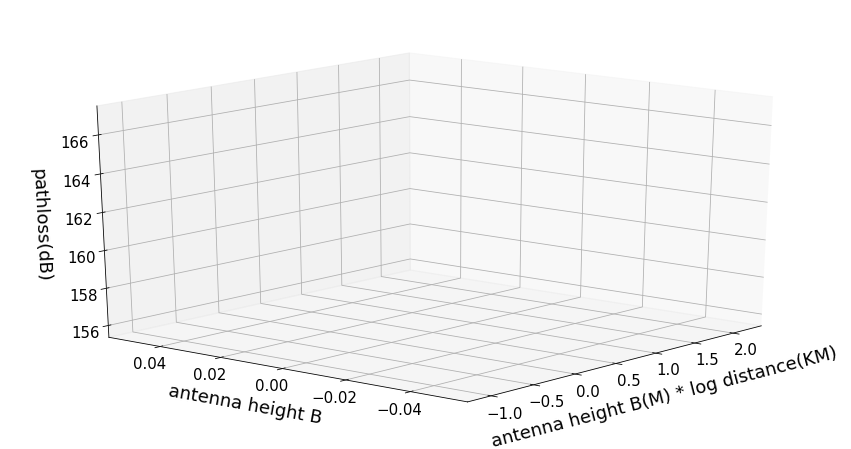

In [8]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logHeightB']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

Equation Derivation for trainset #1
Group- -0.52Ghz Data shape:(8, 7)
Group-  1.91Ghz Data shape:(3, 7)
ANN-Model-1-train error(RMSE): 0.0765082931269932
ANN-Model-1-test error(RMSE): 5.947026766984039
MultiLinear-1-train error(RMSE): 2.3575960800545444
MultiLinear-1-test error(RMSE): 4.002119496804424
L_pathloss = (  0.05 +   0.05log_hb)log_d +   0.07log_f +   0.00log_hb +   0.00log_hm +  -0.70log_(h_tb/h_tm) + 165.48
RMSE(ANN-MultiLinear): 2.326468219580772


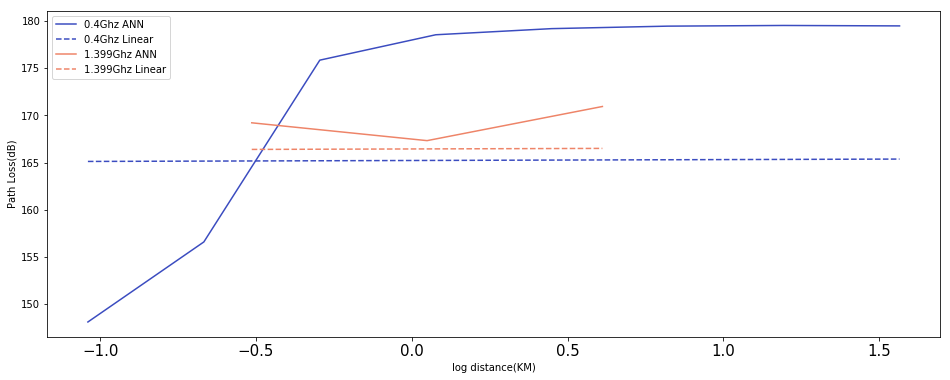

Equation Derivation for trainset #2
Group- -0.52Ghz Data shape:(8, 7)
Group-  1.91Ghz Data shape:(3, 7)
ANN-Model-2-train error(RMSE): 0.08502582293448341
ANN-Model-2-test error(RMSE): 6.505592943546026
MultiLinear-2-train error(RMSE): 2.8452402983777407
MultiLinear-2-test error(RMSE): 0.9208810554463417
L_pathloss = (  0.74 +   0.74log_hb)log_d +  -0.48log_f +   0.00log_hb +   0.00log_hm +  -1.40log_(h_tb/h_tm) + 165.42
RMSE(ANN-MultiLinear): 2.818263048002684


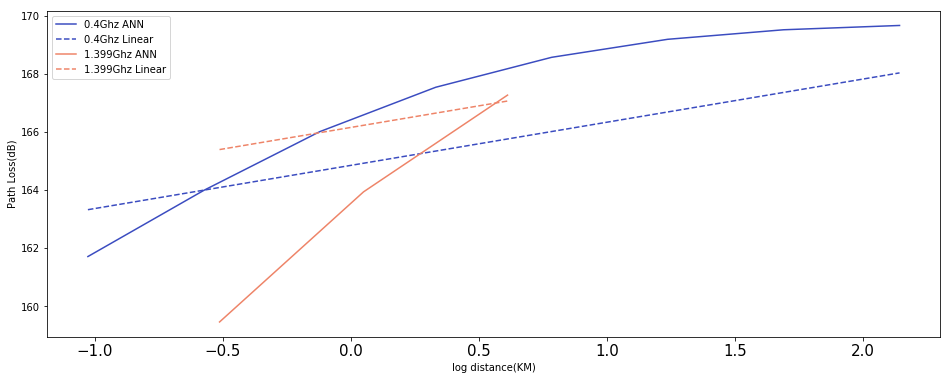

Equation Derivation for trainset #3
Group- -0.52Ghz Data shape:(9, 7)
Group-  1.91Ghz Data shape:(2, 7)
ANN-Model-3-train error(RMSE): 0.8879145136476817
ANN-Model-3-test error(RMSE): 5.059493453978751
MultiLinear-3-train error(RMSE): 1.6085649366939052
MultiLinear-3-test error(RMSE): 4.998238540938641
L_pathloss = (  0.99 +   0.99log_hb)log_d +  -0.14log_f +   0.00log_hb +   0.00log_hm +  -1.85log_(h_tb/h_tm) + 164.96
RMSE(ANN-MultiLinear): 1.3204035047548563


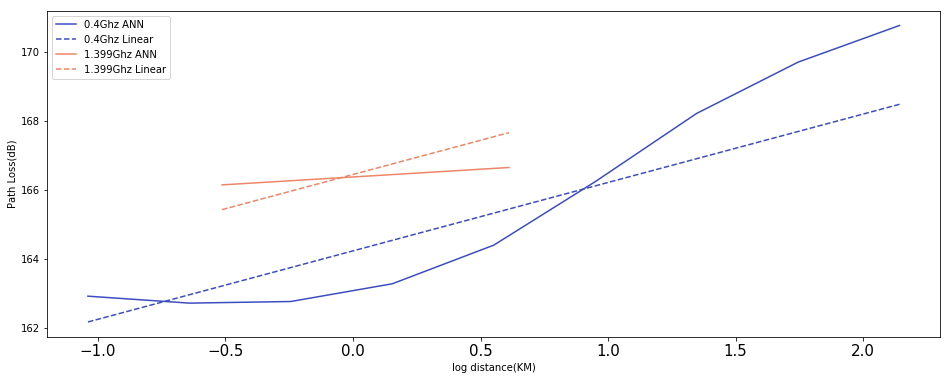

Equation Derivation for trainset #4
Group- -0.52Ghz Data shape:(9, 7)
Group-  1.91Ghz Data shape:(2, 7)
ANN-Model-4-train error(RMSE): 0.675925287843238
ANN-Model-4-test error(RMSE): 1.1907772284170393
MultiLinear-4-train error(RMSE): 2.7696853768201515
MultiLinear-4-test error(RMSE): 2.137699374306001
L_pathloss = (  0.88 +   0.88log_hb)log_d +  -0.30log_f +   0.00log_hb +   0.00log_hm +  -1.10log_(h_tb/h_tm) + 165.88
RMSE(ANN-MultiLinear): 2.659432198093989


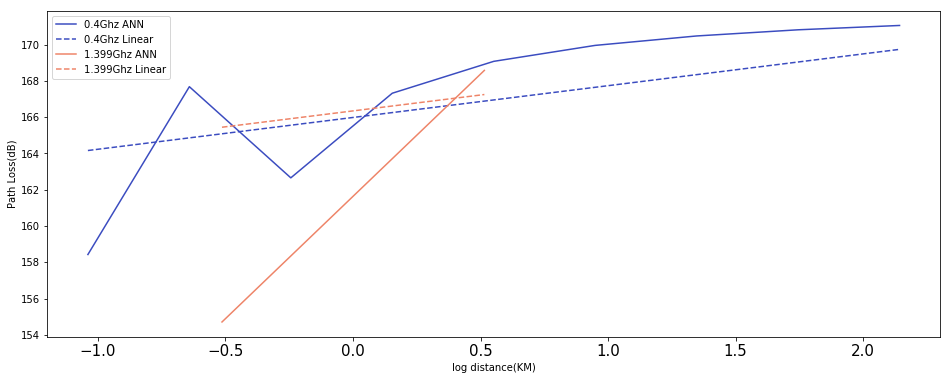

Equation Derivation for trainset #5
Group- -0.52Ghz Data shape:(10, 7)
Group-  1.91Ghz Data shape:(2, 7)
ANN-Model-5-train error(RMSE): 0.6813812564520056
ANN-Model-5-test error(RMSE): 13.879222230054754
MultiLinear-5-train error(RMSE): 2.4780906626654384
MultiLinear-5-test error(RMSE): 4.706508302583747
L_pathloss = (  1.22 +   1.22log_hb)log_d +  -2.44log_f +   0.00log_hb +   0.00log_hm +  -2.89log_(h_tb/h_tm) + 165.03
RMSE(ANN-MultiLinear): 2.3588534402668064


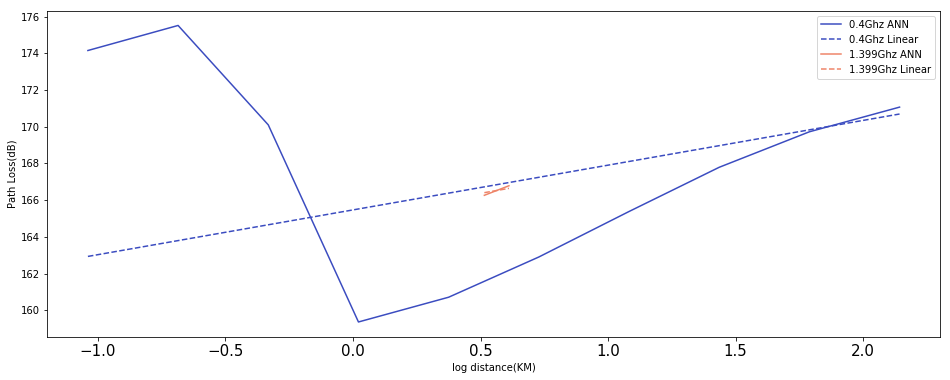

In [9]:
%autoreload
i = 1
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("="*120)
    print("Equation Derivation for trainset #{}".format(i))
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM', 'logHeightTratio'])

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = Ridge(alpha=0.001).fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
    print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)
    
    if manual_normalize:
        print("\nObjective Function with manual normalization data")
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1]*10,\
                      linearModel.coef_[2]*10,linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))    
    else:
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1],\
                      linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))

    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    graphX = data[0]
    graphY = data[1]
    ann_linear_compare_graph(ANNmodel, linearModel, graphX, graphY)

    i+=1